<a href="https://colab.research.google.com/github/Jibbie17/xray/blob/main/xray_vision_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the latest version with CNN. -- Zewei (Whiskey), May 13

Team: X-Ray Vision
Group Members:
- Gabriel Barrett
- Ruben Gallardo
- Zewei (Whiskey) Liao

# Set-Up

In [20]:
# Standard way to load google drive -- essentially change the working dir to your google drive
# DO NOT CHANGE the follow two lines
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# This might be subject to change depending on your g-drive file structure, but
# I rec that you save te shared folder `xray-vision-ml-proj` under the same path here
proj_folder_path = '/content/drive/My Drive/xray-vision-ml-proj/'
data_folder_path = proj_folder_path + 'data-pooled-for-resplit/'
data_csv_path = data_folder_path + "data.csv"

In [22]:
%ls
print(data_folder_path)

drive/  sample_data/
/content/drive/My Drive/xray-vision-ml-proj/data-pooled-for-resplit/


In [23]:
from pathlib import Path
from PIL import Image
import pandas as pd
import json
import os
from collections import namedtuple
import matplotlib.pyplot as plt
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.io import read_image
import re
from sklearn.model_selection import train_test_split

# Resplit the Dataset (DON'T RUN)

In [ ]:
Image_Stats = namedtuple('Image_Stats', ["label", "image_name", "path"])

def construct_df(data_folder_path):
    '''
    Pull the label, file name, and file path of each image and compile into a df
    for later re-spliting.
    '''
    # a list of tuples for later conversion into pandas df
    tup_list = []

    # loop over the only two options of subfolders: NORMAL or PNEUMONIA
    for folder_name in ["NORMAL", "PNEUMONIA"]:
      folder_path = os.path.join(data_folder_path, folder_name)

      # loop over each x-ray image file
      for file_name in os.listdir(folder_path):
        if file_name == '.DS_Store':
          continue
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path):
          img_label = 1 if folder_name == 'PNEUMONIA' else 0
          # compile into a tuple for each image
          tup = Image_Stats(img_label, file_name, file_path)
          tup_list.append(tup)

    return tup_list

tup_list = construct_df(data_folder_path)
df = pd.DataFrame(tup_list)
df = df.reset_index()

# RESPLIT
# Splitting data into train and temp (temp will be split into validation and test)
train, temp = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)

# Splitting temp into validation and test
valid, test = train_test_split(temp, test_size=(2/3), stratify=temp['label'], random_state=42)

# Assigning split labels
train['split'] = 'train'
valid['split'] = 'valid'
test['split'] = 'test'

# Combining the splits back into a single DataFrame
df_resplit = pd.concat([train, valid, test])

df_resplit.to_csv(data_csv_path, index = False)

# Verifying the splits
print(df_resplit['split'].value_counts())

split
train    4070
test     1164
valid     581
Name: count, dtype: int64


In [ ]:
df_resplit.head(5)

,index,label,image_name,path,split
2116,2116,1,person736_virus_1358.jpeg,/content/drive/My Drive/xray-vision-ml-proj/da...,train
3435,3435,1,person547_bacteria_2292.jpeg,/content/drive/My Drive/xray-vision-ml-proj/da...,train
2359,2359,1,person895_virus_1547.jpeg,/content/drive/My Drive/xray-vision-ml-proj/da...,train
906,906,0,NORMAL2-IM-1271-0001.jpeg,/content/drive/My Drive/xray-vision-ml-proj/da...,train
3273,3273,1,person438_bacteria_1889.jpeg,/content/drive/My Drive/xray-vision-ml-proj/da...,train


# Pre-Processing & Summary Stats [DON'T RUN]

In [ ]:
Image_Stats = namedtuple('Image_Stats', ["split", "label", "sick_type", "width", "height", "pixels_sq", "ratio", "channels", "image_name", "path"])

METRICS = ["widths", "heights", "pixels_sq", "ratios", "channels"]

def compile_stats(data_path):
    '''
    This function takes a path that specifies the root directory where the
    data folders are located, finds each file and saves each file's
    reference information in a named tuple called "Image_Stats." This function
    then returns a list of the named tuples and a dicitonary of summary statistics
    that summarizes statistics for all of the tuples.

    Takes: data_path (str), a string specifying the root of the directory where
    the path is located.

    Returns:

    '''
    # a list of tuples for later conversion into pandas df
    tup_list = []
    sum_stats = {}

    # iterate through the level 1 folders -- test, train, and val
    for folder_l1 in os.listdir(data_path):
        # ignore the irrelevant doc / folders
        if folder_l1 in ('.DS_Store', '__MACOSX'):
            continue
        fl1 = os.path.join(data_path, folder_l1)

        # checking if it is a folder
        if not os.path.isdir(fl1):
            continue
        sum_stats[folder_l1] = {}
        for folder_l2 in os.listdir(fl1):
            # iterating through Normal and Pnemonia
            if folder_l2 == '.DS_Store':
                continue
            fl2 = os.path.join(fl1, folder_l2)
            if not os.path.isdir(fl2):
                continue
            sum_stats[folder_l1][folder_l2] = {}

            for filename in os.listdir(fl2):
                # iterating through images
                if filename == '.DS_Store':
                    continue
                f = os.path.join(fl2, filename)
                # checking if it is a file
                if not os.path.isfile(f):
                    continue

                image_obj = Image.open(f)

                #initializing empty lists of summary statistics
                for m in METRICS:
                    sum_stats[folder_l1][folder_l2][m] = sum_stats[folder_l1][folder_l2].get(m, [])

                #fillin in the summary statistics
                sum_stats[folder_l1][folder_l2]["widths"].append(image_obj.width)
                sum_stats[folder_l1][folder_l2]["heights"].append(image_obj.height)

                #calculating square pixels
                square_pixels = int(image_obj.height) * int(image_obj.width)
                sum_stats[folder_l1][folder_l2]["pixels_sq"].append(square_pixels)

                ratio = int(image_obj.width)/int(image_obj.height)
                sum_stats[folder_l1][folder_l2]["ratios"].append(ratio)

                #counting the number of layers / channels
                channels = image_obj.getbands()
                sum_stats[folder_l1][folder_l2]["channels"].append(len(channels))

                img_label = 1 if folder_l2 == 'PNEUMONIA' else 0

                # Checking if the Label is Bacteria or Virus
                if folder_l2 == 'PNEUMONIA':
                    str_path = str(filename)
                    if re.search("virus", str_path):
                        sick = "Virus"
                    else:
                        sick = "Bacteria"
                else:
                    sick = "Normal"

                tup = Image_Stats(folder_l1, img_label, sick, image_obj.width, image_obj.height, square_pixels, ratio, len(channels), filename, f)
                tup_list.append(tup)

                del image_obj

    return sum_stats, tup_list

In [ ]:
dic, tup_list = compile_stats(data_folder_path)
df = pd.DataFrame(tup_list)

# Verify DataFrame
df.head(10)

In [ ]:
# reload the data df
df = pd.read_csv(data_csv_path)
df.head(5)

,index,label,image_name,path,split
0,2895,1,person406_bacteria_1818.jpeg,/content/drive/My Drive/xray-vision-ml-proj/da...,train
1,873,0,NORMAL2-IM-1224-0001.jpeg,/content/drive/My Drive/xray-vision-ml-proj/da...,train
2,3069,1,person413_bacteria_1833.jpeg,/content/drive/My Drive/xray-vision-ml-proj/da...,train
3,4004,1,person1709_bacteria_4522.jpeg,/content/drive/My Drive/xray-vision-ml-proj/da...,train
4,5620,1,person122_bacteria_584.jpeg,/content/drive/My Drive/xray-vision-ml-proj/da...,train


In [ ]:
# save
df.to_csv(data_csv_path, index = False)

In [ ]:
df["ratio"].mean()

#Presenting the averages for each summary statistic.

df[["width", "height", "ratio", "channels"]].mean()

In [ ]:
# Ploting the distributing of each summary statistic.
df[["width", "height", "ratio", "channels"]].hist()

Based on these summary statistics the vast majority of images are landscape, meaning that the width is longer than the height. Almost all the images have only one channel, meaning they are in greyscale, but it appears 283 images have three channels meaning their data is held in rgb.

In [ ]:
df_channels = df[["channels"]]
df_channels[df[["channels"]]==3].count()

channels    283
dtype: int64

# Create DataFrame & Fix Class Imbalance

### Copy Normal Images in Training Data

We will create two copies of the normal training data. Then, we will add these copies to our training dataset to help with the class imbalance problem.

In [24]:
normal_train_images = df.loc[(df['label'] == 0) & (df['split'] == 'train')]
df = pd.concat([df, normal_train_images, normal_train_images]).reset_index(drop=True)

We implemented a custom Dataset class based on [this PyTorch documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files). This class will help us do our image augmentations later on.

In [25]:
# Custom PyTorch Image Dataset Class
# Code Resource: https://pytorch.org/tutorials/beginner/basics/data_tutreadorial.html#creating-a-custom-dataset-for-your-files

# inheriting from the pytorch Dataset class
class CustomImageDataset(Dataset): # TODO maybe change the name later on
    def __init__(self, df, transform = None):
        """
        df (pandas df): pandas dataframe
        split: "train", "valid", or "test"
        transform: Compose (a PyTorch Class) that strings together several
        transform functions (e.g. data augmentation steps)
        """
        #self.df = df
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        """
        Returns: (int) length of your dataset
        """
        return len(self.df)

    def __getitem__(self, idx):
        """
        Loads and returns your sample (the image and the label) at the
        specified index

        Parameter: idx (int): index of interest

        Returns: image, label
        """

        img_path = Path(self.df.loc[idx, 'path'])
        image = Image.open(img_path).convert('RGB')
        label = self.df.loc[idx, 'label']

        # Image Transformation
        if self.transform:
            image = self.transform(image)

        # Returns augmented and/or normalized image with label
        # Label = 1 if pneumonia and label = 0 if normal # TODO do we need to specify the label?
        return image, label

In [26]:
# Augmentation for Training Data
# The list below are the OLD augmentations we used for the first checkpoint
old_augmentations = T.Compose([
    T.Resize((256, 256)),
    T.RandomHorizontalFlip(p=0.5),  # Horizontal flip with prob of 0.5
    T.RandomVerticalFlip(p=0.5),    # Vertical flip with prob of 0.5
    T.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.75, 1.33)),  # Rescaling
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Shifts image horizontally or vertically by 10%
    T.ColorJitter(brightness=0.2, contrast=0.2),  # Randomly changes brightness and contrast
    T.RandomRotation(degrees=10), # Random rotation
    T.Grayscale(num_output_channels=1),  # Convert images to grayscale
    T.ToTensor()  # Convert images to tensors
])

# Augmentation for Training Data
# The augmentations below are the new ones that I took from: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8330434/
augmentations = T.Compose([
    T.Resize((256, 256)),

    # every image has 50/50 chance of being flipped horizontally
    T.RandomHorizontalFlip(p=0.5),

    # every image will be rescaled and cropped, but how it gets rescaled and cropped will be random
    # scale param defines the range of the area of the image to be used in the crop.
    # (scale = 0.8, 1.0) means the cropped area will be at least 80% to 100% of the image area
    # ratio param defines the range of aspect ratios for the cropped area
    # 0.75 means the aspect ratio (width/height) can be as low as 3:4
    # 1.33 means the aspect ratio (width/height) can be as high as 4:3
    T.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.75, 1.33)),

    # The brightness and contrast of every image will be randomly changed
    # brightness=0.2 means the brightness factor is chosen randomly from the range [0.8, 1.2]
    # contrast=0.2 means the contrast factor is chosen randomly from the range [0.8, 1.2]
    T.ColorJitter(brightness=0.2, contrast=0.2),

    # All images are rotated by a random angle within the range [-10, 10]
    # Notice that 0 is included in the range, which means some images will NOT be rotated
    T.RandomRotation(degrees=10), # Random rotation

    # RandomApply applies a list of transformations randomly based on the given probability (p=0.5)
    # kernel_size=(5,5): This specifies the size of the Gaussian kernel. In this case, the kernel is a 5x5 matrix.
    # sigma=(0.1, 0.2): This specifies the range of standard deviation for the Gaussian kernel.
    # The actual standard deviation used for blurring is chosen randomly from the range [0.1, 0.2]
    T.RandomApply([
            T.GaussianBlur(kernel_size=(5,5), sigma=(0.1, 0.2))
        ], p=0.5),

    # The two transformations below make the images compatible with the dataloader and model
    T.Grayscale(num_output_channels=1),  # Convert images to grayscale
    T.ToTensor()  # Convert images to tensors
])

# Normalization for Validation and Test datasets
normalizations = T.Compose([
    T.Resize((256, 256)),
    T.Grayscale(num_output_channels=1),  # Convert images to grayscale
    T.ToTensor()
])

# Augmentation Examples [DON'T RUN]


For data augmentation, we conducted a literature scan of data augmentation methods used in medical image deep learning, with a focus on studies that use chest X-ray images. We identified horizontal flipping, rescaling,  shifting, rotation, brightness and contrast changes to be the most common methods that also make sense to our study. We implemented them as a starting point, keeping in mind they are hyperparameters we can revisit and readjust later depending on model performance.

### Original Sample Image

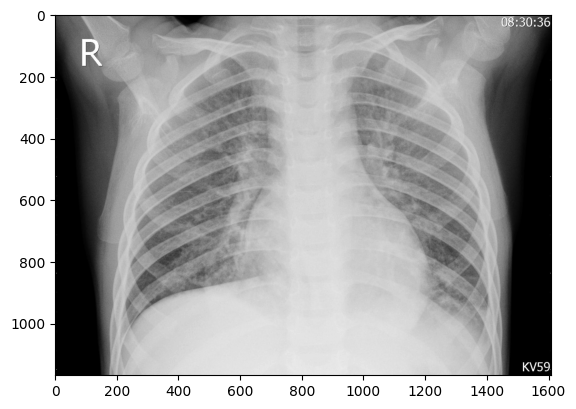

In [ ]:
# Random Horizontal Flip
image = read_image(alt_directory + '/train/PNEUMONIA/person141_virus_287.jpeg')

image = image.squeeze() # Remove the channel dimension because it's grayscale
plt.imshow(image, cmap='grey')
plt.show()

### Random Horizonal Flip

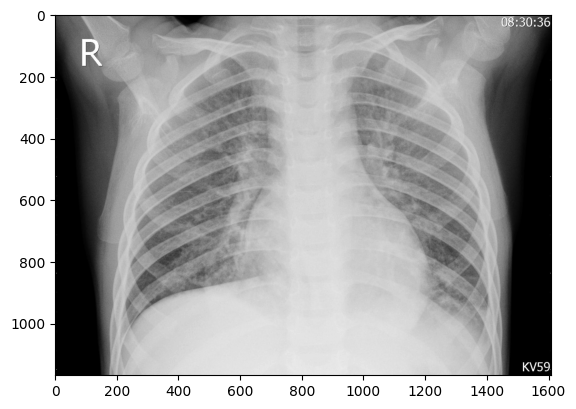

In [ ]:
# Random Horizontal Flip with probability of 0.5
image = T.RandomHorizontalFlip(p=0.5)(image)

image = image.squeeze() # Remove the channel dimension because it's grayscale
plt.imshow(image, cmap='grey')
plt.show()

### Rescaling

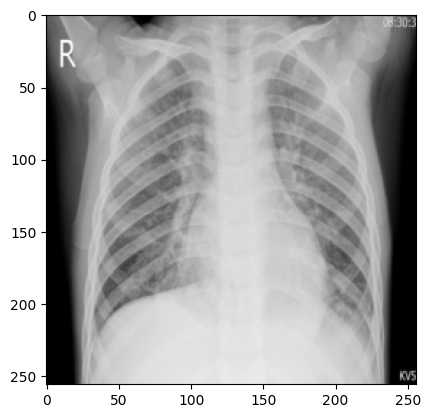

In [ ]:
# Add a batch dimension
image = image.unsqueeze(0)  # Reshape from (C, H, W) to (1, C, H, W)

# Rescaling
image = T.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.75, 1.33))(image)

# Remove the batch dimension for displaying
image = image.squeeze(0)

# Display the image
plt.imshow(image.squeeze(), cmap='grey')
plt.show()

### Random Shifting

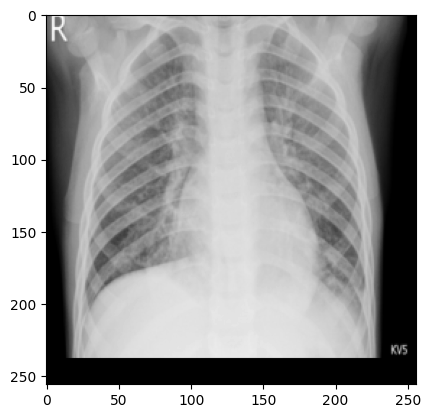

In [ ]:
# Add a batch dimension
image = image.unsqueeze(0)  # Reshape from (C, H, W) to (1, C, H, W)

# Shifts image horizontally or vertically by 10%
image = T.RandomAffine(degrees=0, translate=(0.1, 0.1))(image)

# Remove the batch dimension for displaying
image = image.squeeze()

plt.imshow(image, cmap='grey')
plt.show()

### Random Changes to Brightness & Contrast

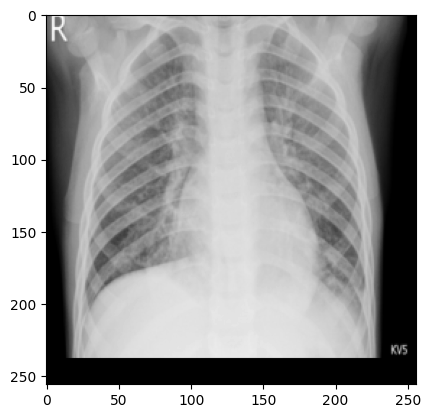

In [ ]:
# Add a batch dimension
image = image.unsqueeze(0)  # Reshape from (C, H, W) to (1, C, H, W)

# Randomly changes brightness and contrast
T.ColorJitter(brightness=0.2, contrast=0.2)(image)

# Remove the batch dimension for displaying
image = image.squeeze()  # Now image is (C, H, W) again

plt.imshow(image, cmap='grey')
plt.show()

### Random Rotation

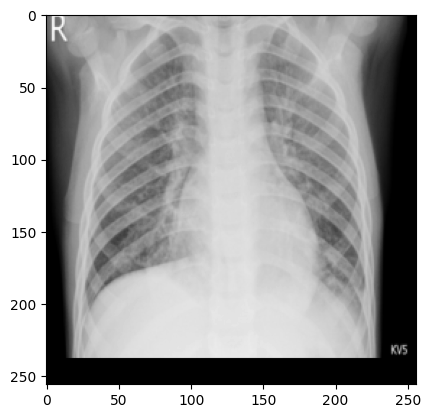

In [ ]:
# Add a batch dimension
image = image.unsqueeze(0)  # Reshape from (C, H, W) to (1, C, H, W)

# Randomly changes brightness and contrast
T.RandomRotation(degrees=10)(image)

# Remove the batch dimension for displaying
image = image.squeeze()  # Now image is (C, H, W) again

plt.imshow(image, cmap='grey')
plt.show()

# Split, Summarize, Load Data

After extracting the summary statistics of our images and storing them in a DataFrame, we prepared the data for the DataLoader by separating out the summary statistic into a training, test, and validation DataFrame. We also created a table that shows how many images fall into the normal or pneumonia group for each dataset.

In [27]:
# Creating separate DataFrame's for the training, validation, and test set
test_df = df.loc[df.loc[:, 'split'] == 'test']
train_df = df.loc[df.loc[:, 'split']=='train']
valid_df = df.loc[df.loc[:, 'split'] == 'valid']

# Count the occurrences of each label
train_counts = train_df['label'].value_counts().sort_index()
val_counts = valid_df['label'].value_counts().sort_index()
test_counts = test_df['label'].value_counts().sort_index()

# Prepare Data for summary table
summary_data = {
    'Normal': [train_counts.get(0, 0), val_counts.get(0, 0), test_counts.get(0, 0)],
    'Pneumonia': [train_counts.get(1, 0), val_counts.get(1, 0), test_counts.get(1, 0)]
}

# Create a summary table
summary_df = pd.DataFrame(summary_data, index=['Train', 'Validation', 'Test'])
summary_df

,Normal,Pneumonia
Train,9711,2991
Validation,154,427
Test,309,855


In [28]:
df

,index,label,image_name,path,split
0,2895,1,person406_bacteria_1818.jpeg,/content/drive/My Drive/xray-vision-ml-proj/da...,train
1,873,0,NORMAL2-IM-1224-0001.jpeg,/content/drive/My Drive/xray-vision-ml-proj/da...,train
2,3069,1,person413_bacteria_1833.jpeg,/content/drive/My Drive/xray-vision-ml-proj/da...,train
3,4004,1,person1709_bacteria_4522.jpeg,/content/drive/My Drive/xray-vision-ml-proj/da...,train
4,5620,1,person122_bacteria_584.jpeg,/content/drive/My Drive/xray-vision-ml-proj/da...,train
...,...,...,...,...,...
14442,579,0,NORMAL2-IM-0832-0001.jpeg,/content/drive/My Drive/xray-vision-ml-proj/da...,train
14443,43,0,IM-0553-0001-0002.jpeg,/content/drive/My Drive/xray-vision-ml-proj/da...,train
14444,350,0,NORMAL2-IM-0476-0001.jpeg,/content/drive/My Drive/xray-vision-ml-proj/da...,train
14445,429,0,NORMAL2-IM-0619-0001.jpeg,/content/drive/My Drive/xray-vision-ml-proj/da...,train


## Data Loader

Based on [this PyTorch documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders), we passed each dataset to a DataLoader. As the documentation states, this will help us pass random mini-batches of the data to our model.

In [29]:
# Defining path for each dataset
# test_dir = os.path.join(data_folder_path, 'test')
# train_dir = os.path.join(data_folder_path, 'train')
# val_dir = os.path.join(data_folder_path, 'val')

# Creating a CustomImageDataset object for each dataset
train_data = CustomImageDataset(train_df, augmentations) # changed parameter from augmentations to old_augmentations
valid_data = CustomImageDataset(valid_df, normalizations)
test_data = CustomImageDataset(test_df, normalizations)

# Source: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(valid_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [30]:
train_data.df.loc[1]
#print("DataFrame index range:", train_df.index.min(), "to", train_df.index.max())
#img_path = Path(self.df.loc[idx, 'path'])

index                                                       873
label                                                         0
image_name                            NORMAL2-IM-1224-0001.jpeg
path          /content/drive/My Drive/xray-vision-ml-proj/da...
split                                                     train
Name: 1, dtype: object

## Iterate through Training DataLoader

To validate that our Data Loader is working, we are displaying one image from a mini-batch below with the code below. Most of the code below comes from the PyTorch documentation [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#iterate-through-the-dataloader).

Feature batch shape: torch.Size([64, 1, 256, 256])
Labels batch shape: torch.Size([64])


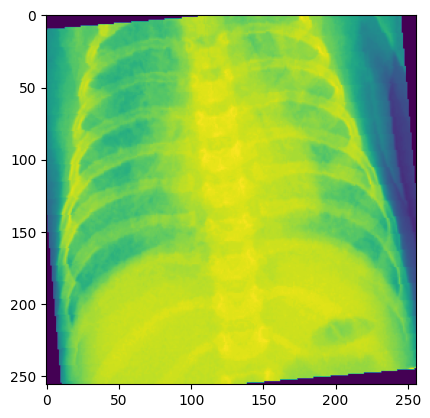

In [31]:
# Code Source: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#iterate-through-the-dataloader

# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[21].squeeze() # Change the index (0 to 63) to display a different image in batch
label = train_labels[1] # [0] for Normal & [1] for Pneumonia

#img = img.permute(1, 2, 0)  # Change the shape to (256, 256, 3)
plt.imshow(img)
plt.show()
print(f"Label: {label}")

# Building the Neural Network

In [32]:
import torch
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, recall_score, RocCurveDisplay
import numpy as np
import matplotlib.pyplot as plt

In [33]:
class CustomNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # The attributes below let us save all of the predictions and actual labels in the class
        # when we are ready to evaluate. These are set in predict_all as numpy arrays.
        # objects.
        self.predictions = None
        self.y = None
        # The y_score is the "predicted probability" as opposed to the prediciton
        # This is needed for the ROC-AUC curve
        self.y_score = None
        # We will save our metrics in a dictionary. The dictioary will be filled on a
        # call to evaluate_model ()
        self.metrics = {}

        # inspire by Turing award winning LeCun, Bengio and Hinton's paper from 1998
        # https://ieeexplore.ieee.org/document/726791 (cited more than 25,000 times!!!!!!!!!)
        # code from https://blog.paperspace.com/writing-lenet5-from-scratch-in-python/

        self.LeNet = nn.Sequential(
            # convolutional layers
            nn.Sequential(                                            # FIRST LAYER: (INPUT LAYER)
              nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5, stride= 1, padding = 0),    # CONVOLUTION
              # Matches the number of output channels from the previous layer.
              # This normalizes the output from the convolution layer, stabilizing the learning process.
              nn.BatchNorm2d(num_features = 6),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size = 2, stride = 2)),             # POOLING
            nn.Sequential(                                            # SECOND LAYER: HIDDEN LAYER 1
              nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1, padding = 0),   # CONVOLUTION
              nn.BatchNorm2d(num_features = 16),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size = 2, stride = 2)),             # POOLING
            # fully connected layers
            nn.Flatten(),
            nn.Linear(in_features = 59536, out_features = 120),                                   # THIRD LAYER: LINEAR YEAR, HIDDEN LAYER 2
            nn.ReLU(),                                                # HIDDEN LAYER's ACTIVATION FUNCION
            nn.Linear(in_features = 120, out_features = 84),                                       # FOURTH LAYER: LINEAR YEAR, HIDDEN LAYER 3
            nn.ReLU(),                                                # HIDDEN LAYER's ACTIVATION FUNCION
            # output layer
            nn.Linear(in_features = 84, out_features = 2)                                          # OUTPUT LAYER
        )

    def confusion_matrix(self):
      cm = confusion_matrix(self.y, self.predictions)
      cm_display = ConfusionMatrixDisplay(cm).plot()

    def roc_curve(self):
      # This function returns an roc curve, which graphs the false positive
      # and true positive rate.
      if self.y is None or self.predictions is None:
        self.predict_all()
      false_pos_rate, true_pos_rate, thresholds = roc_curve(self.y, self.predictions)
      # Plot the curve
      plt.plot(false_pos_rate, true_pos_rate)
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('ROC Curve')
      plt.show()

    def evaluate_model(self, re_test = False):

      if self.predictions is None or self.y is None or re_test is True:
        self.predict_all()
      # calculate accuracy
      total_tests = len(self.y)
      got_right = np.sum((self.y == self.predictions))
      acc = got_right/total_tests
      self.metrics["accuracy"] = acc
      # calculate recall
      recall = recall_score(self.predictions, self.y)
      self.metrics["recall"] = recall
      #area under the roc curve
      self.metrics["auc_roc"] = roc_auc_score(self.predictions,self.y)

    def predict_all(self, data_loader):
        model.train()
        beta_list = []
        y_list= []
        y_score_list = []
        for i, data in enumerate(data_loader):
          x, y = data
          outputs = model(x)
          max_value, predicted = torch.max(outputs.data, 1)
          y_list.append(y)
          beta_list.append(predicted)
        # We combine each lists (predictions and label) then convert them
        # to numpy arrays
        self.predictions = torch.cat(beta_list, dim = 0).detach().cpu().numpy()
        self.y = torch.cat(y_list, dim = 0).detach().cpu().numpy()

    def forward(self, x, visibility = True):
        out = self.LeNet(x)
        #if visibility is True:
          #print(out.shape)  # This will show you the output shape at each step

        return out
        # return F.log_softmax(out, dim=1)


In [34]:
model = CustomNeuralNetwork()

# 3: Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# TESTING CELL
# Just trying to understand how train works

model.train()
for i, data in enumerate(train_dataloader):
  inputs, labels = data
  # Zero the parameter gradients
  optimizer.zero_grad()

  # Forward pass
  outputs = model(inputs) # forward propagation
  # Calculate accuracy
  max_value, predicted = torch.max(outputs.data, 1) # 1 here refers to the column-wise comparison in a batch
  print(f"predicted: {predicted}")
  break


predicted: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0])


In [ ]:
# Number of epochs
EPOCHS = 30

# Lists to keep track of losses and accuracies
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(EPOCHS):  # loop over the dataset multiple times

    # TRAIN
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    model.train()  # Set the model to training mode
    for i, data in enumerate(train_dataloader):
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs) # forward propagation
        loss = criterion(outputs, labels) # criterion, or loss function, which is CrossEntropyLoss here
        loss.backward() # backward propagation
        optimizer.step() # update the weights

        # Calculate loss
        running_loss += loss.item() # item() gets the scalar value held in the loss

        # Calculate accuracy
        # finds the index of the maximum value in each row of outputs.data
        max_value, predicted = torch.max(outputs.data, 1) # 1 here refers to the column-wise comparison in a batch
        # increments total_train by the number of examples in the current batch.
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / (i + 1)
    train_losses.append(avg_train_loss)
    avg_train_acc = correct_train / total_train
    train_accuracies.append(avg_train_acc)

    # VALIDATE
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # In validation phase we don't need to compute gradients (for memory efficiency)
        for i, data in enumerate(val_dataloader):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = running_loss / (i + 1)
    val_losses.append(avg_val_loss)
    avg_val_acc = correct_val / total_val
    val_accuracies.append(avg_val_acc)

    # Print epoch summary
    print(f'Epoch {epoch + 1}/{EPOCHS}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}')

Epoch 1/30, Train Loss: 0.2972, Train Acc: 0.8719, Val Loss: 0.2085, Val Acc: 0.9449
Epoch 2/30, Train Loss: 0.1901, Train Acc: 0.9269, Val Loss: 0.8976, Val Acc: 0.6334
Epoch 3/30, Train Loss: 0.1752, Train Acc: 0.9355, Val Loss: 0.4402, Val Acc: 0.8554
Epoch 4/30, Train Loss: 0.1674, Train Acc: 0.9396, Val Loss: 0.2593, Val Acc: 0.8881
Epoch 5/30, Train Loss: 0.1674, Train Acc: 0.9394, Val Loss: 0.1550, Val Acc: 0.9552
Epoch 6/30, Train Loss: 0.1594, Train Acc: 0.9411, Val Loss: 0.5615, Val Acc: 0.7676
Epoch 7/30, Train Loss: 0.1520, Train Acc: 0.9414, Val Loss: 0.1014, Val Acc: 0.9535
Epoch 8/30, Train Loss: 0.1506, Train Acc: 0.9442, Val Loss: 0.3821, Val Acc: 0.8451
Epoch 9/30, Train Loss: 0.1460, Train Acc: 0.9441, Val Loss: 0.4316, Val Acc: 0.8090
Epoch 10/30, Train Loss: 0.1503, Train Acc: 0.9428, Val Loss: 0.1255, Val Acc: 0.9501
Epoch 11/30, Train Loss: 0.1397, Train Acc: 0.9472, Val Loss: 0.8145, Val Acc: 0.7091


# OLD CODE

In [ ]:
# OLD CODE:
# 4: Train and validate the network
EPOCHS = 50

train_losses = []
train_accuracies = []
val_losses = []
val_accuarcies = []

for _ in range(EPOCHS):  # loop over the dataset multiple times

    # TRAIN
    # Make sure gradient tracking is on, and do a pass over the data
    # sets the model to training mode, enabling features like dropout and batch normalization specific to this mode.
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data           # NOTE: depending on how you implemented your dataset class's __getitem__ it could be labels, inputs

      # resets gradients of all parameters to zero; this is necessary before a new optimization step.
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = model(inputs) # computes the forward pass using the given inputs.
      loss = criterion(outputs, labels) # criterion, or loss function, is CrossEntropyLoss here
      loss.backward() # conduct backward propagation
      optimizer.step() # update the weights

      # keep track of the loss
      running_loss += loss.item()

      # ALSO CALCULATE YOUR ACCURACY METRIC

    avg_train_loss = running_loss / (i + 1)     # i + 1 gives us the total number of batches in train dataloader
    # CALCULATE AVERAGE ACCURACY METRIC
    # avg_train_loss =  FIXME
    train_losses.append(avg_train_loss)
    # train_accuracies.append(avg_train_acc) FIXME

    #VALIDATE
    # in the validation part, we don't want to keep track of the gradients
    model.eval()

    # implement a similar loop!
    # but you can leave out loss.backward()